In [16]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Load your data
df = pd.read_csv('food_supplements.csv')

# Convert 'Sold_date' to datetime format
df['Sold_date'] = pd.to_datetime(df['Sold_date'], format='%m/%d/%y')
df.set_index('Sold_date', inplace=True)

# Aggregate sales data on a weekly basis for each product
weekly_sales = df.groupby([pd.Grouper(freq='W'), 
'Product_details']).agg(total_sold=('Sold_quantity', 'sum')).reset_index()

# Apply one-hot encoding to 'Product_details'
weekly_sales_encoded = pd.concat([weekly_sales, pd.get_dummies(weekly_sales['Product_details'], 
prefix='product')], axis=1).drop('Product_details', axis=1)

# Extract year and week number from 'Sold_date' for temporal features
weekly_sales_encoded['year'] = weekly_sales_encoded['Sold_date'].dt.year
weekly_sales_encoded['week_of_year'] = weekly_sales_encoded['Sold_date'].dt.isocalendar().week

# Normalize the temporal features 
scaler = MinMaxScaler()
features_columns = ['year', 'week_of_year'] + [col for col in weekly_sales_encoded.columns 
if col.startswith('product')]
weekly_sales_encoded[features_columns] = scaler.fit_transform(weekly_sales_encoded[features_columns])

# Split the data into features and target
X = weekly_sales_encoded[features_columns].values
y = weekly_sales_encoded['total_sold'].values

# Adjusting the dataset split into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is roughly 15% of the whole

# Define the model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),  # Additional hidden layer
    Dense(100, activation='relu'),  # Additional hidden layer
    Dense(100, activation='relu'),  # Additional hidden layer
    Dense(1, activation='relu')    # Output layer
])


# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model with the validation data
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=10)

# Evaluate the model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE on test set: {rmse}')

# Prepare forecasting features for Feb 1 to 8, 2024, correctly this time
forecast_results = []
for product_col in [col for col in features_columns if col.startswith('product')]:
    forecast_period_features = np.zeros((1, len(features_columns)))
    # Find the index of the year, week_of_year, and current product column
    year_index = features_columns.index('year')
    week_of_year_index = features_columns.index('week_of_year')
    product_index = features_columns.index(product_col)
    
    # Normalize year and week_of_year values
    forecast_period_features[0, year_index] = (2024 - scaler.data_min_[year_index]) / (scaler.data_max_[year_index] - scaler.data_min_[year_index])
    forecast_period_features[0, week_of_year_index] = (5 - scaler.data_min_[week_of_year_index]) / (scaler.data_max_[week_of_year_index] - scaler.data_min_[week_of_year_index])
    forecast_period_features[0, product_index] = 1  # Activate current product

    # Predict and store the result
    predicted_quantity = model.predict(forecast_period_features).flatten()[0]
    product_name = product_col.replace('product_', '')  # Assuming prefix 'product_' is used
    forecast_results.append((product_name, predicted_quantity))

# Display forecasted quantities for each product in a DataFrame
forecast_df = pd.DataFrame(forecast_results, columns=['Product', 'Forecasted Quantity']).sort_values(by='Forecasted Quantity', ascending=False)
# Save forecast_df to an Excel file
forecast_df.to_excel('forecast_results.xlsx', index=False)


Epoch 1/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - loss: 1992.0952 - val_loss: 546.1642
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 670.8068 - val_loss: 494.6397
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 626.8054 - val_loss: 542.9922
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 605.9968 - val_loss: 443.6274
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 551.4291 - val_loss: 463.7834
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 486.6646 - val_loss: 414.7211
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 456.6307 - val_loss: 471.5320
Epoch 8/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 477.0737 - val_loss: 380.2084
Epoch 9/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 394.1959 - val_loss: 383.7240
Epoch 10/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 461.3804 - val_loss: 355.2289
Epoch 11/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 416.

404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 342.4882 - val_loss: 441.0948
Epoch 66/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 319.2469 - val_loss: 374.0654
Epoch 67/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 325.7312 - val_loss: 369.8743
Epoch 68/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 292.2018 - val_loss: 374.1981
Epoch 69/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 336.9413 - val_loss: 367.2468
Epoch 70/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 341.9587 - val_loss: 371.6733
Epoch 71/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 344.5464 - val_loss: 379.3362
Epoch 72/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 333.5357 - val_loss: 356.5658
Epoch 73/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 301.0129 - val_loss: 399.0044
Epoch 74/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 291.0174 - val_loss: 368.8459
Epoch 75/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 317.2512 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


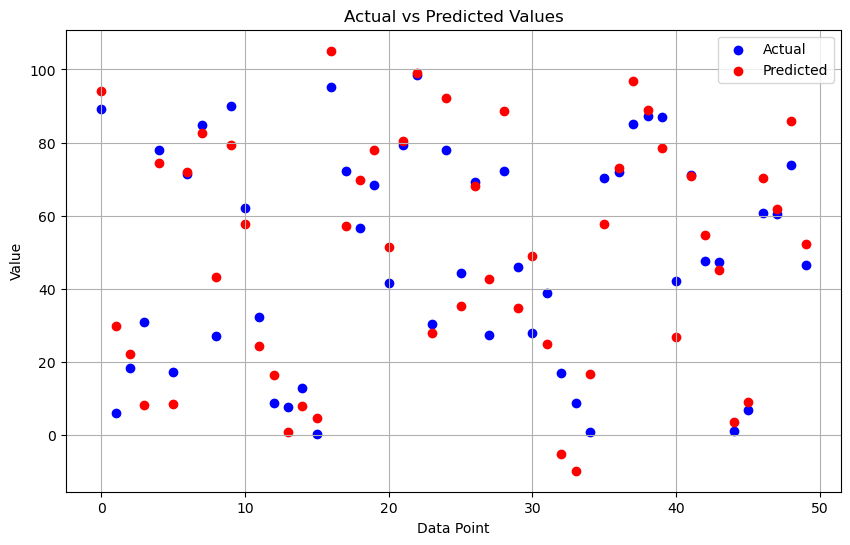

In [2]:
import numpy as np

# Example actual and predicted values
actual_values = np.random.rand(50) * 100
predicted_values = actual_values + np.random.randn(50) * 10

# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual')
plt.scatter(range(len(predicted_values)), predicted_values, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


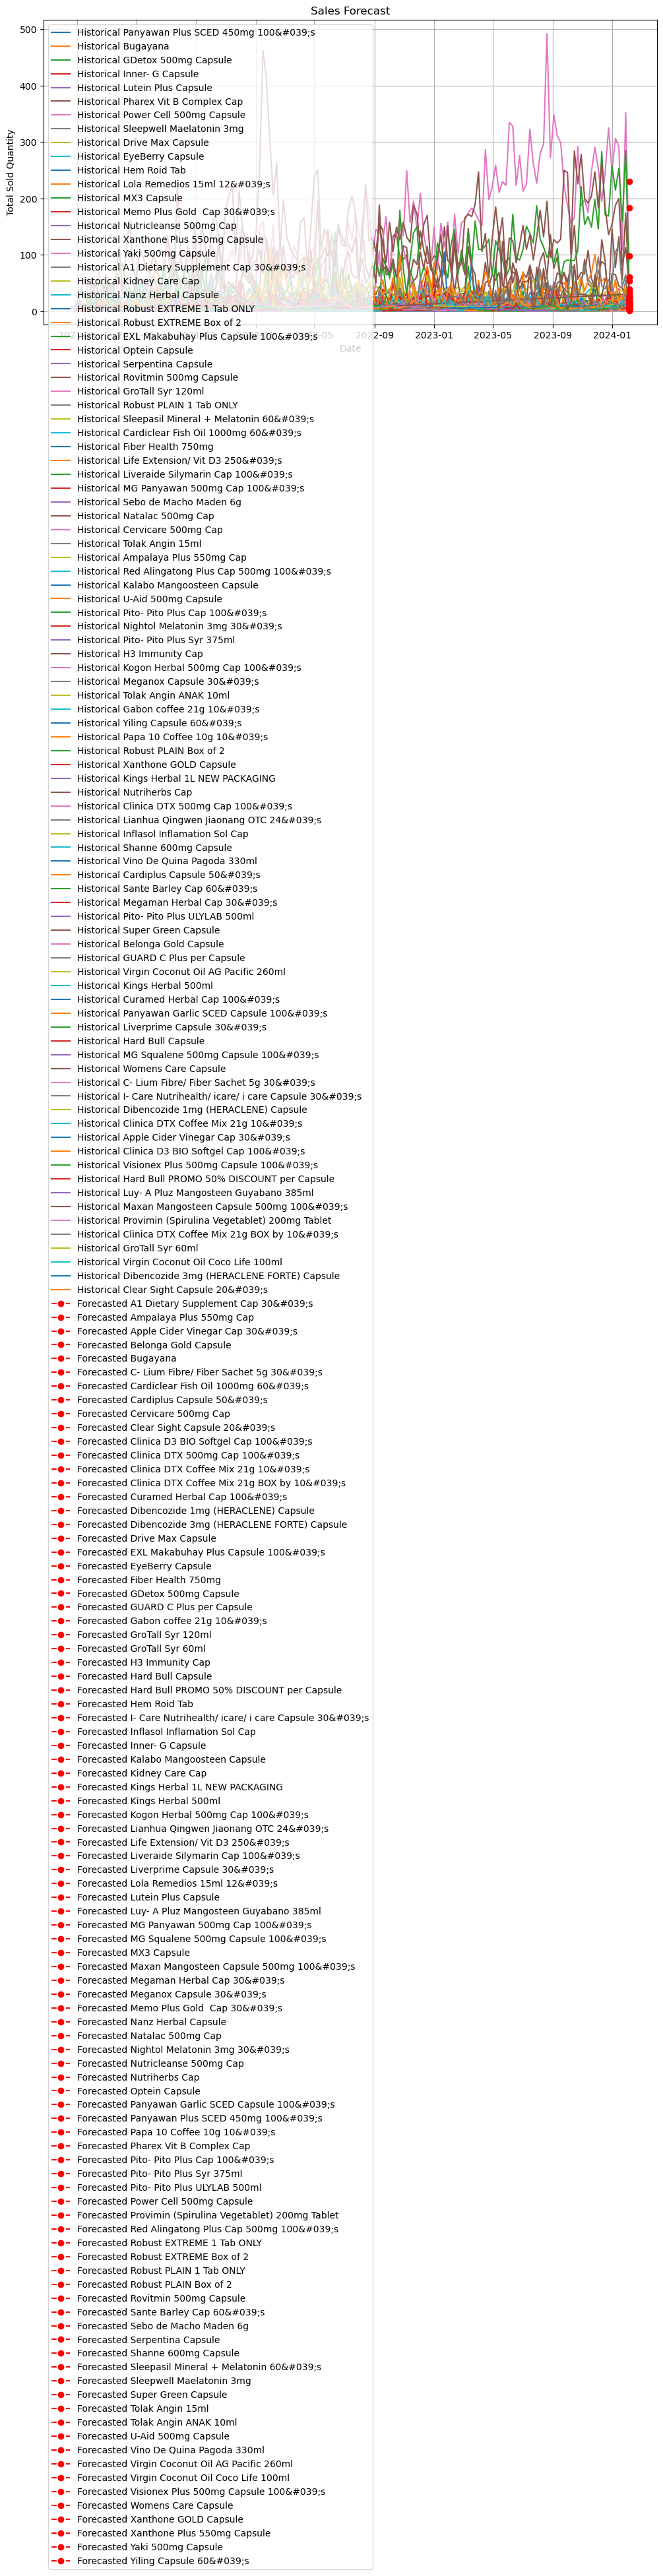

In [3]:
import matplotlib.pyplot as plt

# Assume weekly_sales is the original weekly aggregated sales data

# Plot historical data
plt.figure(figsize=(12, 6))
for product in weekly_sales['Product_details'].unique():
    product_data = weekly_sales[weekly_sales['Product_details'] == product]
    plt.plot(product_data['Sold_date'], product_data['total_sold'], label=f'Historical {product}')

# Plot forecasted data with gaps
for product, quantity in forecast_results:
    forecast_dates = pd.date_range(start='2024-02-01', periods=1, freq='W')
    plt.plot(forecast_dates, [quantity], 'ro--', label=f'Forecasted {product}')  # 'ro--' for red dotted lines with circles

plt.xlabel('Date')
plt.ylabel('Total Sold Quantity')
plt.title('Sales Forecast')
plt.legend()
plt.grid(True)
plt.show()
